# Processing large images in Python

In this notebook we will process a large OME-Zarr image from the BioImage Archive using dask.

First, we will set up the processing steps on a small crop of the image, and then we will apply the same processing to the entire image, or a larger part of it, using dask.

Finally, we'll save the processed image on our local computer.

## Let's load a large image

In this example we want to process a large image which doesn't fit into the memory of our computer and which we could not process without making use of dask. This is an example of such an image:

https://uk1s3.embassy.ebi.ac.uk/bia-integrator-data/S-BIAD515/IM4/IM4.zarr/B/4/0

As seen before, we can view the image with web viewers using the link below (e.g. use vizarr):

https://ome.github.io/ome-ngff-validator/?source=https://uk1s3.embassy.ebi.ac.uk/bia-integrator-data/S-BIAD515/IM4/IM4.zarr/B/4/0

![large_image_screenshot.png](images/large_image_screenshot.png)

## Analysis goal

Segmentation will be performed in another session of this workshop.

Here, let's try to process the DAPI channel such that the irregular patterns on the DAPI channel are removed.

Specifically, these are the steps we will perform:
1. Select the DAPI channel
1. Maximum project along the Z axis
1. Apply adaptive histogram equalization
1. Save the processed image as a new OME-Zarr image


## Perform the analysis

Define the URL

In [1]:
url = "https://uk1s3.embassy.ebi.ac.uk/bia-integrator-data/S-BIAD515/IM4/IM4.zarr/B/4/0"

Read the image using ngff-zarr

In [2]:
import ngff_zarr as nz

multiscales = nz.from_ngff_zarr(url)
multiscales

/Users/malbert/miniconda3/envs/day3/lib/python3.11/site-packages/zarr/creation.py:610: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)
/Users/malbert/miniconda3/envs/day3/lib/python3.11/site-packages/zarr/creation.py:610: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)
/Users/malbert/miniconda3/envs/day3/lib/python3.11/site-packages/zarr/creation.py:610: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)
/Users/malbert/miniconda3/envs/day3/lib/python3.11/site-packages/zarr/creation.py:610: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)
/Users/malbert/miniconda3/envs/day3/lib/python3.11/site-packages/zarr/creation.py:610: UserWarning: ignoring keyword argument 'read_only'
  compressor, 

Multiscales(images=[NgffImage(data=dask.array<astype, shape=(1, 4, 5, 30311, 20257), dtype=uint16, chunksize=(1, 1, 1, 1024, 1024), chunktype=numpy.ndarray>, dims=['t', 'c', 'z', 'y', 'x'], scale={'t': 1.0, 'c': 1.0, 'z': 2.0, 'y': 0.149346898349, 'x': 0.149346898349}, translation={'t': 0.0, 'c': 0.0, 'z': 0.0, 'y': 0.0, 'x': 0.0}, name='image', axes_units={'t': None, 'c': None, 'z': 'micrometer', 'y': 'micrometer', 'x': 'micrometer'}, computed_callbacks=[]), NgffImage(data=dask.array<astype, shape=(1, 4, 5, 15155, 10128), dtype=uint16, chunksize=(1, 1, 1, 1024, 1024), chunktype=numpy.ndarray>, dims=['t', 'c', 'z', 'y', 'x'], scale={'t': 1.0, 'c': 1.0, 'z': 2.0, 'y': 0.298693796698, 'x': 0.298693796698}, translation={'t': 0.0, 'c': 0.0, 'z': 0.0, 'y': 0.0, 'x': 0.0}, name='image', axes_units={'t': None, 'c': None, 'z': 'micrometer', 'y': 'micrometer', 'x': 'micrometer'}, computed_callbacks=[]), NgffImage(data=dask.array<astype, shape=(1, 4, 5, 7577, 5064), dtype=uint16, chunksize=(1, 1

## Inspecting the image

How large is the image?

In [3]:
import numpy as np

print('Image shape is', multiscales.images[0].data.shape)
print('Corresponding to a disk size of', np.prod(multiscales.images[0].data.shape) * 2 / 10**9, 'GB')

Image shape is (1, 4, 5, 30311, 20257)
Corresponding to a disk size of 24.56039708 GB


⚠️  Loading the image into memory would be a bad idea.

Therefore, let's work with dask arrays.

Specifically, let's load the highest resolution image available into a variable called `img_dask`.

```python

In [4]:
img_dask = multiscales.images[0].data
img_dask

dask.array<astype, shape=(1, 4, 5, 30311, 20257), dtype=uint16, chunksize=(1, 1, 1, 1024, 1024), chunktype=numpy.ndarray>

What are the dimensions of the image? Is there time, channel, z?

Dimension metadata is present in `multiscales.images`

In [5]:
multiscales.images[0].dims

['t', 'c', 'z', 'y', 'x']

What's the pixel spacing of the image?

In [6]:
multiscales.images[0].scale

{'t': 1.0, 'c': 1.0, 'z': 2.0, 'y': 0.149346898349, 'x': 0.149346898349}

We can get further metadata about the channels from the 'omero' metadata of the OME-Zarr image.

In [7]:
import zarr

root = zarr.group(url)
root.attrs["omero"]

{'channels': [{'color': '0092FF',
   'coefficient': 1,
   'active': True,
   'label': 'DAPI',
   'window': {'min': 0.0, 'max': 12408.0, 'start': 0.0, 'end': 12408.0},
   'family': 'linear',
   'inverted': False},
  {'color': '004747',
   'coefficient': 1,
   'active': True,
   'label': 'Opal 650',
   'window': {'min': 0.0, 'max': 43792.0, 'start': 0.0, 'end': 43792.0},
   'family': 'linear',
   'inverted': False},
  {'color': '00CF00',
   'coefficient': 1,
   'active': True,
   'label': 'Opal 570',
   'window': {'min': 0.0, 'max': 31576.0, 'start': 0.0, 'end': 31576.0},
   'family': 'linear',
   'inverted': False},
  {'color': '00FF00',
   'coefficient': 1,
   'active': False,
   'label': 'Opal 520',
   'window': {'min': 0.0, 'max': 21359.0, 'start': 0.0, 'end': 21359.0},
   'family': 'linear',
   'inverted': False}],
 'rdefs': {'defaultT': 0, 'model': 'color', 'defaultZ': 2}}

We see that DAPI is channel 0. Let's select it, as well as the first time point (time is on axis 0 as seen above).

In [8]:
time_index = 0
channel_index = 0

img_t0_c0 = img_dask[time_index, channel_index]
img_t0_c0

dask.array<getitem, shape=(5, 30311, 20257), dtype=uint16, chunksize=(1, 1024, 1024), chunktype=numpy.ndarray>

Next, we'll crop the image to a smaller size in order to speed up the processing for the sake of this tutorial. However, all the following code will also work with larger crops or the full image.

In [9]:
x0, y0 = 9000, 9000
dx, dy = 1500, 1500

# the first dimension is z, which we don't crop in this step
img_cropped = img_t0_c0[:, y0:y0+dy, x0:x0+dx]
img_cropped

dask.array<getitem, shape=(5, 1500, 1500), dtype=uint16, chunksize=(1, 1024, 1024), chunktype=numpy.ndarray>

## Z projection

We decided to work on 2D projections. Here we create a maximum projection along the z dimension and we make sure the resulting array is still a dask array.

In [10]:
img_proj = img_cropped.max(axis=0)
img_proj

dask.array<max-aggregate, shape=(1500, 1500), dtype=uint16, chunksize=(1024, 1024), chunktype=numpy.ndarray>

Let's plot the maximum projection using matplotlib.

⚠️ This should only be done for small crops, for larger parts of the image skip this step.

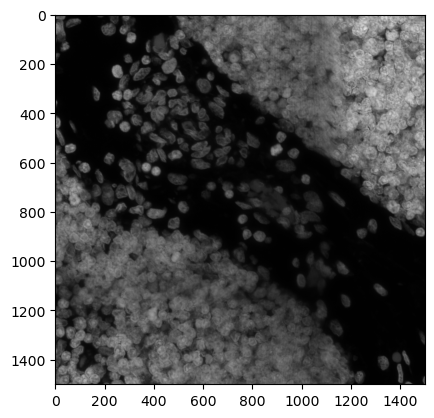

In [11]:
import matplotlib.pyplot as plt

plt.figure()
plt.imshow(img_proj, cmap='gray')

## Normalizing the image

To correct for uneven brightness in the image, we'll use adaptive histogram equalization. This is a common technique in image processing that enhances the contrast of an image by transforming the pixel intensity values based on the local histogram of pixel intensities.

![image.png](images/sphx_glr_plot_adapt_hist_eq_3d_001.png)

Adaptive histogram equalization is implemented in skimage as `skimage.exposure.equalize_adapthist`. This function takes an image and a few parameters, including the clip limit and the kernel size. The clip limit is used to limit the contrast enhancement, and the kernel size determines the size of the local region used for histogram equalization.

It's important to note that the function expects a 2D numpy array as input. Let's apply the adaptive histogram equalization to our cropped image.

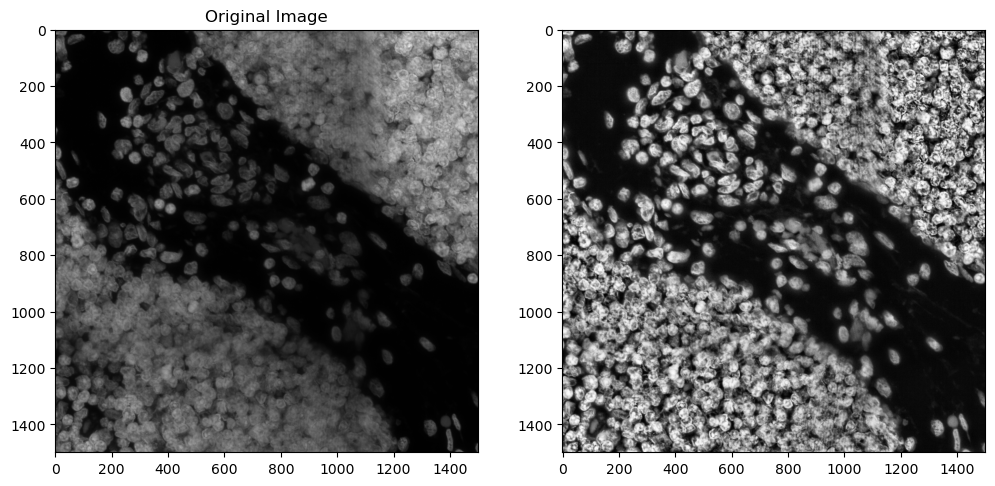

In [12]:
from skimage.exposure import equalize_adapthist

img_proj_numpy = img_proj.compute()

img_proj_proc = equalize_adapthist(img_proj_numpy, kernel_size=50, clip_limit=0.02, nbins=256)

# plot the original and processed images next to each other

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(img_proj_numpy, cmap='gray')
ax[0].set_title('Original Image')
ax[1].imshow(img_proj_proc, cmap='gray')


### Making the processing function dask compatible

As seen in the previous practical, we can apply a function to a dask array using the `map_blocks` method. This method applies the function to each block of the dask array, allowing us to process large arrays without loading them into memory all at once.

In [13]:
img_norm = img_proj.map_blocks(
    equalize_adapthist,
    kernel_size=200,
    clip_limit=0.02,
    nbins=256,
    dtype=np.float32,
)

img_norm.compute()

array([[0.76578073, 0.70413437, 0.68106312, ..., 0.28372604, 0.2386766 ,
        0.27475278],
       [0.77285591, 0.74160207, 0.73194291, ..., 0.29416433, 0.22121841,
        0.25528019],
       [0.76578073, 0.72855912, 0.67140396, ..., 0.2654743 , 0.21328287,
        0.33433036],
       ...,
       [0.23713606, 0.24562046, 0.30617103, ..., 0.81644324, 0.82603616,
        0.91821424],
       [0.2097296 , 0.21735946, 0.24494903, ..., 0.75796335, 0.87043414,
        0.87578404],
       [0.22059452, 0.19910883, 0.19605689, ..., 0.71510269, 0.85352355,
        0.88390112]], shape=(1500, 1500))

Let's compute and visualize the result (only for small crops!)

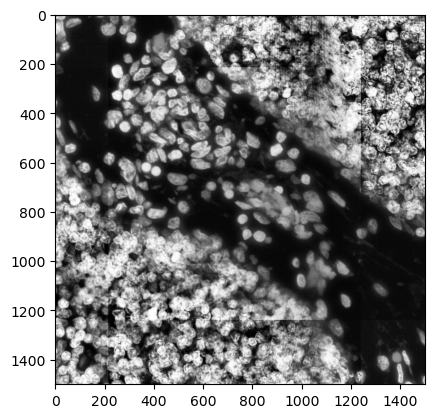

In [14]:
plt.figure()
plt.imshow(img_norm.compute(), cmap='gray')

We can see that there are some boundary artifacts in the image. This comes from the fact that the adaptive histogram equalization is applied to each block independently, without considering the neighboring blocks. To mitigate this, we can introduce some overlap between the blocks. This will ensure that the adaptive histogram equalization takes into account the neighboring blocks, reducing or eliminating the boundary artifacts (depending on the overlap size).


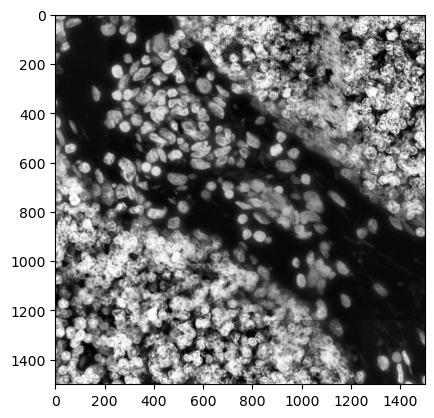

In [15]:
img_norm_overlap = img_proj.map_overlap(
    equalize_adapthist,
    kernel_size=200,
    clip_limit=0.02,
    nbins=256,
    dtype=np.float32,
    depth=50, # 50 pixels overlap seems to be enough to avoid strong artifacts
    boundary='none',
)

plt.figure()
plt.imshow(img_norm_overlap.compute(), cmap='gray')

## Saving the processed image

In the following, we want to save the processed image as a new multiscale pyramidal OME-Zarr image.

We can do this using the `ngff-zarr` library, which provides a convenient way to save dask arrays as OME-Zarr images.

In [16]:
# first we attach some metadata to output the image

ngff_image = nz.NgffImage(
    data=img_norm_overlap,
    dims=['y', 'x'],
    scale=multiscales.images[0].scale, # this is a dictionary e.g. {'x': 0.1, 'y': 0.1}
    translation=multiscales.images[0].translation, # also a dictionary e.g. {'x': 0, 'y': 0}
)

out_multiscales = nz.to_multiscales(
    ngff_image,
    scale_factors=[2], # we want to save one downscaled version of the image (2x downsampled in this case)
)


Up to here, we have only established the processing pipeline we want apply to the input image.

In the following step, we start writing the output (indicating an output file path). Only then can the processing start, as the dask array would otherwise be computed in memory.

In [17]:
import dask.diagnostics

# this gives a progress bar for the dask computation
with dask.diagnostics.ProgressBar():
    nz.to_ngff_zarr(
        'test.ome.zarr',
        out_multiscales,
    )

[########################################] | 100% Completed | 1.98 sms
[########################################] | 100% Completed | 2.19 ss


We can visualize the result:

In [21]:
import os

# os.system('napari test.ome.zarr')
# os.system('ome_zarr view test.ome.zarr')

When visualizing the result, we can see that the DAPI channel is shown in greyscale. This is because the `ngff-zarr` library does not support writing the `omero` channel metadata yet, so we need to write it manually (this is however optional!). When viewing the image again after executing the next cell, the DAPI channel should be shown in blue.

In [19]:
root.attrs["omero"] # this contains the input omero metadata loaded earlier

root_output = zarr.group('test.ome.zarr')
root_output.attrs["omero"] = {
    "channels": [
        root.attrs["omero"]['channels'][0] # output has only one channel and DAPI was channel index 0
    ]
}

## Processing the full image

Now that we've processed a small crop of the image, we're ready to test whether our dask-based pipeline also works on the full image.

### Exercise: Process the full image (or a larger crop)

For this, copy the relevant parts of the code above here or in a new notebook (leaving out the intermediate plotting steps) and run the processing pipeline on a larger image.

In case this takes too long, you could try processing a lower resolution level.
